In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from utils import get_data

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 15]

2021-12-08 15:03:39.059912: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def plot_cm(_model, _X_test, _y_test):
    predictions = _model.predict(_X_test)
    cm = confusion_matrix(_y_test.argmax(axis=1), predictions.argmax(axis=1), normalize="pred")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    
def define_model(inpit_shape):
    ip = Input(shape=(inpit_shape,), name="input")
    x = Dense(units=1024, name="hiddel_layer", activation="relu")(ip)
    x = Dense(units=512, name="hiddel_layer_2", activation="relu")(x)
    x = Dense(units=64, name="hiddel_layer_3", activation="relu")(x)
    op = Dense(units=19, name="prediction", activation="softmax")(x)
    model = Model(inputs=ip, outputs=op, name="full_model")
    model.summary()
    
    learning_rate = 0.001
    optimizer = Adam(learning_rate, amsgrad=True)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [2]:
XY_train, X_test, inverse_target_map = get_data(min_size=None, min_size_test=None, nan_thresh=26, fill_nan=None)
train_columns = list(XY_train.columns)
train_columns.remove("TARGET_NUM")

min_max_scaler = MinMaxScaler(feature_range=(2, 10))
X_train_minmax = min_max_scaler.fit(XY_train[train_columns])
x_train = X_train_minmax.transform(XY_train[train_columns])

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=1)
imp_train = imp.fit(x_train)
x_train_full = imp_train.transform(x_train)

x_train_full_df = pd.DataFrame(x_train_full, columns=train_columns, index=XY_train.index)

min_size = 150

for c in x_train_full_df.columns:
    if c != "TARGET_NUM":
        x_train_full_df[c][x_train_full_df.groupby(c)[c].transform('size') <= min_size] = 0

stand_scaler = StandardScaler()
X_train_stand = stand_scaler.fit(x_train_full_df[train_columns])
x_train_stand = X_train_stand.transform(x_train_full_df[train_columns])

In [7]:
#for cn, max_value in max_v.items():
#    if cn != "TARGET_NUM":
#        XY_train[cn] = XY_train[cn] / max_value

In [8]:
#x_train = XY_train[train_columns].values
#y_train = to_categorical(XY_train["TARGET_NUM"].values)
#X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33)

In [9]:
y_train = to_categorical(XY_train["TARGET_NUM"].values)
X_train, X_test, y_train, y_test = train_test_split(x_train_stand, y_train, test_size=0.33)

In [18]:
model = define_model(X_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    batch_size=100,
                    epochs=150,
                    verbose=1,
                    validation_data=(X_test, y_test))

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 43)]              0         
                                                                 
 hiddel_layer (Dense)        (None, 1024)              45056     
                                                                 
 hiddel_layer_2 (Dense)      (None, 512)               524800    
                                                                 
 hiddel_layer_3 (Dense)      (None, 64)                32832     
                                                                 
 prediction (Dense)          (None, 19)                1235      
                                                                 
Total params: 603,923
Trainable params: 603,923
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
24765/24765 [=========================

24765/24765 [==============================] - 113s 5ms/step - loss: 2.0267 - accuracy: 0.3399 - val_loss: 2.3113 - val_accuracy: 0.2843
Epoch 103/150
24765/24765 [==============================] - 116s 5ms/step - loss: 2.0255 - accuracy: 0.3403 - val_loss: 2.3183 - val_accuracy: 0.2836
Epoch 104/150
24765/24765 [==============================] - 113s 5ms/step - loss: 2.0248 - accuracy: 0.3407 - val_loss: 2.3106 - val_accuracy: 0.2847
Epoch 105/150
24765/24765 [==============================] - 113s 5ms/step - loss: 2.0237 - accuracy: 0.3407 - val_loss: 2.3108 - val_accuracy: 0.2838
Epoch 106/150
24765/24765 [==============================] - 113s 5ms/step - loss: 2.0228 - accuracy: 0.3410 - val_loss: 2.3141 - val_accuracy: 0.2843
Epoch 107/150
24765/24765 [==============================] - 113s 5ms/step - loss: 2.0219 - accuracy: 0.3414 - val_loss: 2.3180 - val_accuracy: 0.2839
Epoch 108/150
24765/24765 [==============================] - 114s 5ms/step - loss: 2.0212 - accuracy: 0.3416

KeyboardInterrupt: 

## RobustScaler

In [3]:
XY_train, X_test, inverse_target_map = get_data(min_size=None, min_size_test=None, nan_thresh=10, fill_nan=None)
train_columns = list(XY_train.columns)
train_columns.remove("TARGET_NUM")

min_max_scaler = MinMaxScaler(feature_range=(0, 10))
X_train_minmax = min_max_scaler.fit(XY_train[train_columns])
x_train = X_train_minmax.transform(XY_train[train_columns])

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)
imp_train = imp.fit(x_train)
x_train_full = imp_train.transform(x_train)

rs = RobustScaler()
rs_train = rs.fit(x_train)
x_train_full = rs_train.transform(x_train_full)

In [4]:
y_train = to_categorical(XY_train["TARGET_NUM"].values)
X_train, X_test, y_train, y_test = train_test_split(x_train_full, y_train, test_size=0.33)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(XY_train["TARGET_NUM"].values),
                                                  XY_train["TARGET_NUM"].values)
class_weight_dict = dict(enumerate(class_weights))

model = define_model(X_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    #class_weight=class_weight_dict,
                    batch_size=100,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test))
plot_cm(model, X_test, y_test)

/home/ad.adasworks.com/levente.peto/aidrms/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], y=[0 1 1 ... 8 4 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
2021-12-08 15:04:13.782351: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-08 15:04:13.822413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2021-12-08 15:04:13.822445: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-12-08 15:04:13.824361: I tenso

Model: "full_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 43)]              0         
_________________________________________________________________
hiddel_layer (Dense)         (None, 1024)              45056     
_________________________________________________________________
hiddel_layer_2 (Dense)       (None, 512)               524800    
_________________________________________________________________
hiddel_layer_3 (Dense)       (None, 64)                32832     
_________________________________________________________________
prediction (Dense)           (None, 19)                1235      
Total params: 603,923
Trainable params: 603,923
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
   28/24765 [..............................] - ETA: 45s - loss: 22.0653 - accuracy: 0.0914

2021-12-08 15:04:15.204042: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


 5206/24765 [=====>........................] - ETA: 48s - loss: 2.6509 - accuracy: 0.2064

## Add columns

In [5]:
XY_train, X_test, inverse_target_map = get_data(min_size=None, min_size_test=None, nan_thresh=40, fill_nan=None)
#for c in XY_train.columns:
#    if c.find("_NUM") == -1:
#        for i in range(2, 4):
#            colname = c + "_{}".format(i)
#            XY_train[colname] = XY_train[c]**i
            
train_columns = list(XY_train.columns)
train_columns.remove("TARGET_NUM")

min_max_scaler = MinMaxScaler(feature_range=(2, 10))
X_train_minmax = min_max_scaler.fit(XY_train[train_columns])
x_train = X_train_minmax.transform(XY_train[train_columns])

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=1)
imp_train = imp.fit(x_train)
x_train_full = imp_train.transform(x_train)

x_train_full_df = pd.DataFrame(x_train_full, columns=train_columns, index=XY_train.index)

min_size = 150

for c in x_train_full_df.columns:
    if c != "TARGET_NUM":
        x_train_full_df[c][x_train_full_df.groupby(c)[c].transform('size') <= min_size] = 0
        
stand_scaler = StandardScaler()
X_train_stand = stand_scaler.fit(x_train_full_df[train_columns])
x_train_stand = X_train_stand.transform(x_train_full_df[train_columns])

y_train = to_categorical(XY_train["TARGET_NUM"].values)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(x_train_stand,
                                                                    y_train,
                                                                    test_size=0.30)

In [6]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(XY_train["TARGET_NUM"].values),
                                                  XY_train["TARGET_NUM"].values)
class_weight_dict = dict(enumerate(class_weights))

model = define_model(X_train_std.shape[1])
history = model.fit(X_train_std,
                    y_train_std,
                    #class_weight=class_weight_dict,
                    batch_size=100,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test_std, y_test_std))

/home/ad.adasworks.com/levente.peto/aidrms/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], y=[0 1 1 ... 1 7 8] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
2021-12-08 13:41:19.225314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64
2021-12-08 13:41:19.225423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64
2021-12-08 13:41:19.225512: W tensorflow/stream_executor/platf

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 43)]              0         
                                                                 
 hiddel_layer (Dense)        (None, 1024)              45056     
                                                                 
 hiddel_layer_2 (Dense)      (None, 512)               524800    
                                                                 
 hiddel_layer_3 (Dense)      (None, 64)                32832     
                                                                 
 prediction (Dense)          (None, 19)                1235      
                                                                 
Total params: 603,923
Trainable params: 603,923
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
12321/12321 [==========================

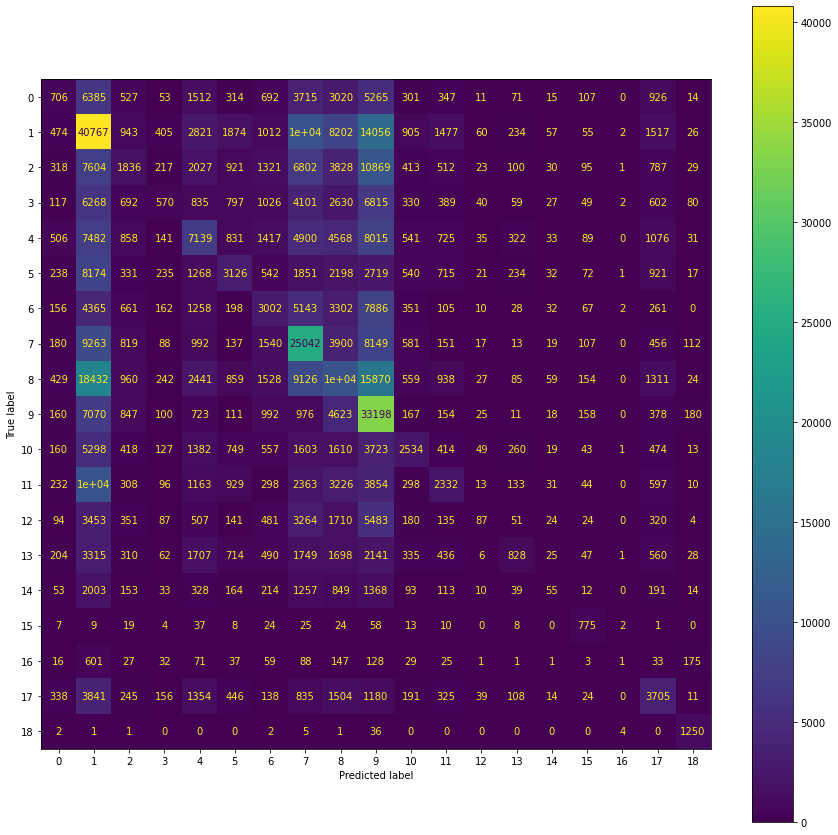

In [7]:
plot_cm(model, X_test_std, y_test_std)

## PCA + NN

In [1]:
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import get_data

%matplotlib inline

2021-12-03 13:59:56.871595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64
2021-12-03 13:59:56.871628: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
XY_train, X_test, inverse_target_map = get_data(min_size=None, min_size_test=None, fill_nan=None)
train_columns = list(XY_train.columns)
train_columns.remove("TARGET_NUM")

min_max_scaler = MinMaxScaler(feature_range=(2, 10))
X_train_minmax = min_max_scaler.fit(XY_train[train_columns])
x_train = X_train_minmax.transform(XY_train[train_columns])

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=1)
imp_train = imp.fit(x_train)
x_train_full = imp_train.transform(x_train)

x_train_full_df = pd.DataFrame(x_train_full, columns=train_columns, index=XY_train.index)

min_size = 150

for c in x_train_full_df.columns:
    if c != "TARGET_NUM":
        x_train_full_df[c][x_train_full_df.groupby(c)[c].transform('size') <= min_size] = 0

stand_scaler = StandardScaler()
X_train_stand = stand_scaler.fit(x_train_full_df[train_columns])
x_train_stand = X_train_stand.transform(x_train_full_df[train_columns])

In [18]:
pca = PCA(n_components=30)
pca_result = pca.fit_transform(x_train_stand)

In [19]:
y_train = to_categorical(XY_train["TARGET_NUM"].values)
X_train, X_test, y_train, y_test = train_test_split(pca_result, y_train, test_size=0.33)

In [ ]:
model = define_model(X_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    batch_size=100,
                    epochs=150,
                    verbose=1,
                    validation_data=(X_test, y_test))

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30)]              0         
                                                                 
 hiddel_layer_2 (Dense)      (None, 512)               15872     
                                                                 
 hiddel_layer_3 (Dense)      (None, 64)                32832     
                                                                 
 prediction (Dense)          (None, 19)                1235      
                                                                 
Total params: 49,939
Trainable params: 49,939
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
24765/24765 [==============================] - 61s 2ms/step - loss: 2.2573 - accuracy: 0.2776 - val_loss: 2.2320 - val_accuracy: 0.2836
Epoch 2/150
22644/24765 [===========

## Drop columns

In [8]:
print(list(XY_train.columns))

['Condition_importance', 'Hospital_death_flag', 'Age', 'Alanine Aminotransferase (ALT)', 'Alkaline Phosphatase', 'Anion Gap', 'Asparate Aminotransferase (AST)', 'Base Excess', 'Bicarbonate', 'Bilirubin, Total', 'Calcium, Total', 'Calculated Total CO2', 'Chloride', 'Creatinine', 'Glucose', 'H', 'Hematocrit', 'Hemoglobin', 'I', 'INR(PT)', 'L', 'MCH', 'MCHC', 'MCV', 'Magnesium', 'PT', 'PTT', 'Phosphate', 'Platelet Count', 'Potassium', 'RDW', 'RDW-SD', 'Red Blood Cells', 'Sodium', 'Urea Nitrogen', 'White Blood Cells', 'pCO2', 'pH', 'pO2', 'Admission_type_NUM', 'Marital_status_NUM', 'Ethnicity_NUM', 'Gender_NUM', 'TARGET_NUM']


In [10]:
columns_for_drop = ["Alanine Aminotransferase (ALT)", "Alkaline Phosphatase", "Base Excess", "Bicarbonate",
                    "Glucose", "H", "INR(PT)", "MCHC", "PTT", "Platelet Count", "Potassium", "RDW", "RDW-SD",
                    "Red Blood Cells", "pCO2", "pH", "pO2", "Admission_type_NUM", "Marital_status_NUM"]

In [12]:
XY_train_filt = XY_train.drop(columns_for_drop, axis=1)

In [13]:
XY_train_filt

,Condition_importance,Hospital_death_flag,Age,Anion Gap,Asparate Aminotransferase (AST),"Bilirubin, Total","Calcium, Total",Calculated Total CO2,Chloride,Creatinine,...,MCV,Magnesium,PT,Phosphate,Sodium,Urea Nitrogen,White Blood Cells,Ethnicity_NUM,Gender_NUM,TARGET_NUM
0,4.0,0.0,56.0,13.0,-2.0,-2.0,9.0,26.0,105.0,1.1,...,92.0,1.9,12.1,3.3,140.0,17.0,10.9,0.0,0.0,0.0
1,7.0,0.0,46.0,14.0,341.0,0.5,9.5,-2.0,105.0,1.3,...,101.0,1.9,13.2,3.3,136.0,21.0,6.5,0.0,0.0,1.0
2,1.0,0.0,69.0,18.0,11.0,0.3,9.7,-2.0,98.0,3.1,...,99.0,1.6,12.2,3.8,138.0,37.0,8.6,0.0,0.0,1.0
3,10.0,0.0,76.0,12.0,72.0,0.4,8.9,23.0,118.0,0.9,...,91.0,2.1,11.8,3.2,134.0,21.0,8.3,0.0,0.0,2.0
4,8.0,0.0,91.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696240,3.0,0.0,0.0,-2.0,-2.0,8.3,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,18.0
3696241,35.0,0.0,57.0,11.0,53.0,2.0,8.0,21.0,99.0,0.6,...,94.0,1.5,16.0,2.4,131.0,10.0,6.9,0.0,1.0,7.0
3696242,6.0,0.0,57.0,18.0,15.0,1.1,9.9,29.0,86.0,1.4,...,85.0,1.9,9.7,3.4,128.0,37.0,8.2,6.0,0.0,8.0
3696243,19.0,0.0,68.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1.0,1.0,4.0


In [14]:
XY_train_filt['MMM'] = XY_train_filt[['Hematocrit', 'Hemoglobin', 'MCV', 'MCH']].mean(axis=1)

In [15]:
XY_train_filt

,Condition_importance,Hospital_death_flag,Age,Anion Gap,Asparate Aminotransferase (AST),"Bilirubin, Total","Calcium, Total",Calculated Total CO2,Chloride,Creatinine,...,Magnesium,PT,Phosphate,Sodium,Urea Nitrogen,White Blood Cells,Ethnicity_NUM,Gender_NUM,TARGET_NUM,MMM
0,4.0,0.0,56.0,13.0,-2.0,-2.0,9.0,26.0,105.0,1.1,...,1.9,12.1,3.3,140.0,17.0,10.9,0.0,0.0,0.0,44.350
1,7.0,0.0,46.0,14.0,341.0,0.5,9.5,-2.0,105.0,1.3,...,1.9,13.2,3.3,136.0,21.0,6.5,0.0,0.0,1.0,46.275
2,1.0,0.0,69.0,18.0,11.0,0.3,9.7,-2.0,98.0,3.1,...,1.6,12.2,3.8,138.0,37.0,8.6,0.0,0.0,1.0,41.200
3,10.0,0.0,76.0,12.0,72.0,0.4,8.9,23.0,118.0,0.9,...,2.1,11.8,3.2,134.0,21.0,8.3,0.0,0.0,2.0,44.025
4,8.0,0.0,91.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,1.0,3.0,-2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696240,3.0,0.0,0.0,-2.0,-2.0,8.3,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,18.0,-2.000
3696241,35.0,0.0,57.0,11.0,53.0,2.0,8.0,21.0,99.0,0.6,...,1.5,16.0,2.4,131.0,10.0,6.9,0.0,1.0,7.0,43.575
3696242,6.0,0.0,57.0,18.0,15.0,1.1,9.9,29.0,86.0,1.4,...,1.9,9.7,3.4,128.0,37.0,8.2,6.0,0.0,8.0,42.625
3696243,19.0,0.0,68.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1.0,1.0,4.0,-2.000


In [16]:
XY_train_filt['ACS'] = XY_train_filt[['Anion Gap', 'Chloride', 'Sodium']].mean(axis=1)

In [17]:
XY_train_filt['ACS'] = XY_train_filt[['Calcium, Total', 'Magnesium', 'Phosphate']].mean(axis=1)

In [19]:
columns_for_drop = ['Hematocrit', 'Hemoglobin', 'MCV', 'MCH'] +\
                   ['Anion Gap', 'Chloride', 'Sodium'] + ['Calcium, Total', 'Magnesium', 'Phosphate']
XY_train_filt = XY_train_filt.drop(columns_for_drop, axis=1)

In [20]:
XY_train_filt

,Condition_importance,Hospital_death_flag,Age,Asparate Aminotransferase (AST),"Bilirubin, Total",Calculated Total CO2,Creatinine,I,L,PT,Urea Nitrogen,White Blood Cells,Ethnicity_NUM,Gender_NUM,TARGET_NUM,MMM,ACS
0,4.0,0.0,56.0,-2.0,-2.0,26.0,1.1,-2.0,-2.0,12.1,17.0,10.9,0.0,0.0,0.0,44.350,4.733333
1,7.0,0.0,46.0,341.0,0.5,-2.0,1.3,-2.0,-2.0,13.2,21.0,6.5,0.0,0.0,1.0,46.275,4.900000
2,1.0,0.0,69.0,11.0,0.3,-2.0,3.1,1.0,4.0,12.2,37.0,8.6,0.0,0.0,1.0,41.200,5.033333
3,10.0,0.0,76.0,72.0,0.4,23.0,0.9,1.0,4.0,11.8,21.0,8.3,0.0,0.0,2.0,44.025,4.733333
4,8.0,0.0,91.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,1.0,3.0,-2.000,-2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696240,3.0,0.0,0.0,-2.0,8.3,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,18.0,-2.000,-2.000000
3696241,35.0,0.0,57.0,53.0,2.0,21.0,0.6,-2.0,-2.0,16.0,10.0,6.9,0.0,1.0,7.0,43.575,3.966667
3696242,6.0,0.0,57.0,15.0,1.1,29.0,1.4,-2.0,-2.0,9.7,37.0,8.2,6.0,0.0,8.0,42.625,5.066667
3696243,19.0,0.0,68.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1.0,1.0,4.0,-2.000,-2.000000


In [21]:
for cn, max_value in XY_train_filt.max().items():
    if cn != "TARGET_NUM":
        XY_train_filt[cn] = XY_train_filt[cn] / max_value

In [27]:
train_columns = list(XY_train_filt.columns)
train_columns.remove("TARGET_NUM")

In [28]:
x_train = XY_train_filt[train_columns].values
y_train = to_categorical(XY_train_filt["TARGET_NUM"].values)
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33)

In [31]:
model = define_model(inpit_shape=16)
history = model.fit(X_train,
                    y_train,
                    batch_size=100,
                    epochs=15,
                    verbose=1,
                    validation_data=(X_test, y_test))

Model: "full_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16)]              0         
_________________________________________________________________
hiddel_layer (Dense)         (None, 256)               4352      
_________________________________________________________________
hiddel_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
prediction (Dense)           (None, 19)                2451      
Total params: 39,699
Trainable params: 39,699
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
24765/24765 [==============================] - 98s 4ms/step - loss: 2.3105 - accuracy: 0.2668 - val_loss: 2.2846 - val_accuracy: 0.2719
Epoch 2/15
24765/24765 [==============================] - 103s 4ms/step - loss: 2.2815 - accuracy: 0.27